In [1]:
!pip install pytorch-lightning wandb --upgrade --quiet
!git clone https://github.com/benihime91/leaf-disease-classification-kaggle.git

Cloning into 'leaf-disease-classification-kaggle'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 137 (delta 75), reused 75 (delta 28), pack-reused 0
Receiving objects: 100% (137/137), 7.04 MiB | 9.93 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [2]:
import warnings
import os
import time

os.chdir("/kaggle/working/leaf-disease-classification-kaggle/")
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# -----------------------
# Import Libraries
# -----------------------
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
import logging
import argparse
import pandas as pd
import wandb
import time

from lightning import LightningModel_resnext50_32x4d as LitModel
from lightning import LitDatatModule
from preprocess import Preprocessor
pd.set_option("display.max_colwidth", None)

# set up paths to the data directories
image_dir = "/kaggle/input/cassava-leaf-disease-classification/train_images"
csv_dir   = "/kaggle/input/cassava-leaf-disease-classification/train.csv"
json_dir  = "/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json"

# set random seeds
random.seed(42)
pl.seed_everything(42)
torch.manual_seed(42)
np.random.seed(42)

# login to wandb: a74f67fd5fae293e301ea8b6710ee0241f595a63
! wandb login "a74f67fd5fae293e301ea8b6710ee0241f595a63"

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Getting the data ready

We generate train/validation/test data corresponding to the particular fold number, after which we will instantiate the `LightningDataModule` class to generate our dataloaders for training.

In [4]:
# since we already have the fold dataset
fold_csv = "/kaggle/working/leaf-disease-classification-kaggle/fold_df.csv"
processor = Preprocessor(csv_dir, json_dir, image_dir, num_folds=5)
# set the dataframe of Preprocessor to the the fold_csv
df = pd.read_csv(fold_csv)
df.filePath = [os.path.join(image_dir, df.image_id[i]) for i in range(len(df))]
processor.dataframe = df
processor.dataframe.head()

,image_id,label,filePath,kfold
0,2615227158.jpg,4,/kaggle/input/cassava-leaf-disease-classification/train_images/2615227158.jpg,0
1,1277648239.jpg,3,/kaggle/input/cassava-leaf-disease-classification/train_images/1277648239.jpg,0
2,2305895487.jpg,3,/kaggle/input/cassava-leaf-disease-classification/train_images/2305895487.jpg,0
3,336299725.jpg,2,/kaggle/input/cassava-leaf-disease-classification/train_images/336299725.jpg,0
4,1951270318.jpg,2,/kaggle/input/cassava-leaf-disease-classification/train_images/1951270318.jpg,0


In [5]:
# -------------------------------
# Grab one FOLD
# -------------------------------

fold_num = 0 # specify the number of the fold

trainFold, valFold = processor.get_fold(fold_num)
testFold, valFold  = train_test_split(valFold, stratify=valFold.label, test_size=0.5) 

trainFold.reset_index(drop=True, inplace=True)
testFold.reset_index(drop=True, inplace=True)
valFold.reset_index(drop=True, inplace=True)

In [6]:
print("Length of train data:", len(trainFold))
print("Length of test data:",  len(testFold))
print("Length of valid data:", len(valFold))

Length of train data: 17117
Length of test data: 2140
Length of valid data: 2140


In [7]:
weights = processor.weights
weights = torch.tensor(list(weights.values()))
weights = 1 - weights
weights

tensor([0.9492, 0.8977, 0.8885, 0.3851, 0.8796])

In [8]:
label_map = processor.label_map
label_map

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [9]:
def imshow(image, targets):
    """Imshow for Tensor."""
    grid = torchvision.utils.make_grid(image, normalize=True, nrow=4).permute(1, 2, 0).data.numpy()
    grid = np.array(grid * 255., dtype=np.uint)
    classes = targets.data.numpy()
    plt.figure(figsize=(15, 10))
    plt.axis("off")
    plt.imshow(grid)
    plt.title([label_map[i] for i in classes]);

**Specify transformations for train/valid/test data**

In [10]:
image_dim = 224 # dimension of the image after resize

# Specify TRANSFORATIONS for TRAIN/VAL/TEST DATALOADERS
train_transformations = A.Compose([
    A.RandomResizedCrop(image_dim, image_dim, p=1.0),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.Resize(image_dim, image_dim, always_apply=True),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),
    ToTensorV2(p=1.0),
])

valid_transformations = A.Compose([
    A.Resize(image_dim, image_dim, always_apply=True),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)
])

test_transformations = valid_transformations

albu_transforms = {
    "train": train_transformations, 
    "valid": valid_transformations,
    "test" : test_transformations,
}

**instantiate `LightningDataModule`**

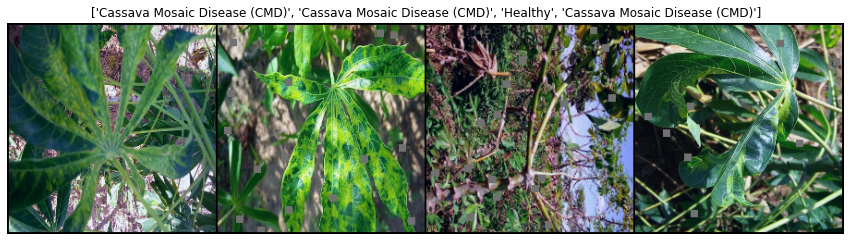

In [11]:
batch_size = 128
dm = LitDatatModule(trainFold, valFold, testFold, batch_size, albu_transforms, num_workers=5, pin_memory=True)
dm.setup()

# grab samples to log predictions on
samples = next(iter(dm.val_dataloader()))

# view sample images
ims, targs = next(iter(dm.train_dataloader()))
imshow(ims[:4], targs[:4])

## Configure Training Pipeline

We set up the training configuration and initiate the `Trainer` class from pytorch-lightning to train our `LightningModule` model

In [12]:
# ----------------------------------
# TRAINING ARGUMENTS
# ----------------------------------
num_epochs = 20
steps_per_epoch = len(dm.train_dataloader())
total_steps = num_epochs * steps_per_epoch

learning_rate = 0.01
weight_decay = 0.00001

output_dims = len(label_map)

# Parse arguments
parser = argparse.ArgumentParser()
parser.add_argument("--learning_rate", type=float, default=learning_rate, help="learning rate")
parser.add_argument("--weight_decay",  type=float, default=weight_decay, help="weight_decay")
parser.add_argument("--total_steps",   type=int, default=total_steps, help="total steps to train for")
parser.add_argument("--output_dims",   type=int, default=output_dims, help="number of output classes")
args, _ = parser.parse_known_args()

logger = logging.getLogger("lightning")
logger.info(f"num_epochs: {num_epochs}")
logger.info(f"steps_per_epoch: {steps_per_epoch}")
logger.info(f"total_steps: {total_steps}")
logger.info(f"learning_rate: {learning_rate}")
logger.info(f"weight_decay: {weight_decay}")
logger.info(f"output_dims: {output_dims}")

num_epochs: 20
steps_per_epoch: 134
total_steps: 2680
learning_rate: 0.01
weight_decay: 1e-05
output_dims: 5


In [13]:
class ImagePredictionLogger(pl.Callback):
    def __init__(self, val_samples, num_samples = 32):
        """
        Upon finishing training log num_samples number
        of images and their predictions to wandb
        """
        super().__init__()
        self.val_imgs, self.val_labels = val_samples
        self.val_imgs   = self.val_imgs[:num_samples]
        self.val_labels = self.val_labels[:num_samples]
          
    def on_fit_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        examples = [wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") for x, pred, y in zip(val_imgs, preds, self.val_labels)]
        trainer.logger.experiment.log({"examples": examples})

In [14]:
# -----------------------------------
# LIGHTNING TRAINER
# ------------------------------------
# init model-checkpoint callback for lightning trainer
PATH = "/kaggle/working/"
chkpt = pl.callbacks.ModelCheckpoint(filepath=PATH, monitor="val_loss", save_top_k=1, mode="min")

# init learning-rate monitor to track learning rates
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="step")

# init wandb logger for pytorch-lightning
run_name = f"resnext50_32x4d|fold={fold_num}|{time.strftime('%H:%M:%S-%Y/%m/%d')}"
wb_logger = pl.loggers.WandbLogger(project="kaggle-leaf-disease", name=run_name)

# init early stopping callback
stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")

# convert all callbacks to a list
cbs = [lr_monitor, ImagePredictionLogger(samples), stopping]

# Init trainer
trainer = pl.Trainer(
    precision=16,
    gpus=1,
    logger=wb_logger,
    checkpoint_callback=chkpt,
    callbacks=cbs,
    max_steps=total_steps,
    log_every_n_steps=10,
)

# log the training config to wandb
wb_logger.log_hyperparams(vars(args))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
wandb: Currently logged in as: ayushman (use `wandb login --relogin` to force relogin)


## Model Training & Evaluation

In this section we instantiate the `LightningModule` model specified in `lightning.py` script. We will then log the model architecture to wandb and use `pytorch-lightning` `Trainer` to train/validate and test the model upon whose completion we will save the weights of the pytorch-model wrapped under the `LightningModule` class.

In [17]:
# init LightningModule
hidden_dims = 512
model = LitModel(**vars(args), hidden_dims=hidden_dims, class_weights=None)
model.example_input_array = torch.zeros_like(ims)

# freeze/unfreeze the feature extractor of the model
model.unfreeze_classifier()

# log model topology to wandb
wb_logger.watch(model.net)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


In [18]:
# Pass the datamodule as arg to trainer.fit to override model hooks :)
trainer.fit(model, dm)


  | Name    | Type                  | Params | In sizes           | Out sizes
-----------------------------------------------------------------------------------
0 | net     | TransferLearningModel | 25 M   | [128, 3, 224, 224] | [128, 5] 
1 | loss_fn | CrossEntropyLoss      | 0      | ?                  | ?        


1

In [22]:
# Compute metrics on test dataset
_ = trainer.test(model, datamodule=dm, ckpt_path=chkpt.best_model_path)

wandb: WARNING Step must only increase in log calls.  Step 2947 < 2948; dropping {'test_loss': 0.4345320463180542, 'test_acc': 0.8542056083679199, 'epoch': 10}.


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.8542, device='cuda:0'),
 'test_loss': tensor(0.4345, device='cuda:0'),
 'train_loss': tensor(0.3975, device='cuda:0'),
 'val_acc': tensor(0.8467, device='cuda:0'),
 'val_loss': tensor(0.4391, device='cuda:0')}
--------------------------------------------------------------------------------



In [25]:
PATH = chkpt.best_model_path # path to the best performing model
WEIGHTS_PATH = f"/kaggle/working/weights_fold={fold_num}.pt"

loaded_model = model.load_from_checkpoint(checkpoint_path=chkpt.best_model_path, **vars(args))
torchmodel = loaded_model.net

# save torch model state dict
torch.save(torchmodel.state_dict(), WEIGHTS_PATH)

Check the saved files :

In [27]:
from torch import nn
from torchvision import models

device = torch.device("cuda:0")

class TransferLearningModel(nn.Module):
    """
    The base for the lightning model
    """
    def __init__(self, classifier: nn.Module, base: nn.Module):
        super(TransferLearningModel, self).__init__()
        # Set our init args as class attributes
        self.classifier = classifier
        self.base = base
        
    def forward(self, x):
        return self.base(self.classifier(x))

In [29]:
# assemble network
classifier = models.resnext50_32x4d()

# dims for the base model
num_ftrs = classifier.fc.out_features
h1 = 512 
h2 = int(h1/2)

base_model = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.ReLU(inplace=True),
    nn.Dropout(0.25),
    nn.Linear(num_ftrs, h1),
    nn.BatchNorm1d(h1),
    nn.ReLU(inplace=True),
    nn.Dropout(0.25),
    nn.Linear(h1, h2),
    nn.BatchNorm1d(h2),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(h2, 5)
)

# init model
Net = TransferLearningModel(classifier, base_model)

# load saved model weights
state_dict = torch.load(WEIGHTS_PATH, map_location=device)
# load the torch state dict to the model
Net.load_state_dict(state_dict)
logger.info("Success")

Success


In [30]:
# save the weights to wandb
# WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.
wandb.save(WEIGHTS_PATH)
# finish run
wandb.finish()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


lr-SGD,0.00024
train_loss,0.44297
epoch,10
_step,2948
_runtime,3258
_timestamp,1606024545
val_loss,0.43909
val_acc,0.84673
test_loss,0.43866
test_acc,0.85327


lr-SGD,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▇█▅▃▃▄▂▄▂▃▂▂▂▂▃▃▄▂▂▂▂▂▁▁▂▂▃▁▂▂▃▂▁▁▁▂▂▁▁▂
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄█
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
val_loss,██▄▂▁▂▁▁▃▁▁
val_acc,▁▁▄▇█▇█▇▇▇▇
test_loss,▁
test_acc,▁
